# ***Reparameterization of common distributions***





We will work with Torch throughout this notebook.

In [1]:
# Install the torch package
%pip install torch

import torch
from torch.distributions import Beta #, ...  import the distributions you need here
from torch.nn import functional as F

### ***Q1. Beta Distribution***
Below write a function that generates N samples from $Beta(a,b)$

In [3]:
def beta_sampler(a, b, N):
  # insert your code
  
  # create a Beta distribution object
  beta = Beta(a, b)

  # sample from the Beta distribution
  samples = beta.sample((N,))

  return samples # should be N-by-1

Now, reparameterize $Beta(a,b)$ via Kumaraswamy(a,b) approximation:

In [2]:
def beta_reparametrize(a, b, N):
    """
    Approximate sampling from Beta(a, b) by reparameterizing via Kumaraswamy(a, b).
    
    Kumaraswamy(a, b) random variable X can be sampled by:
        X = (1 - U^(1/b))^(1/a)
    where U ~ Uniform(0, 1).
    
    This yields an approximation to Beta(a, b) but also provides
    a closed-form reparameterization (useful for gradient-based methods).
    
    Args:
        a (torch.Tensor): shape parameters 'a' (can be scalar or tensor).
        b (torch.Tensor): shape parameters 'b' (can be scalar or tensor).
        N (int): number of samples to draw.
        
    Returns:
        torch.Tensor: a tensor of size (N,) containing samples.
    """

    # Draw N samples from Uniform(0,1)
    u = torch.rand(N, device=a.device if isinstance(a, torch.Tensor) else None)
    
    # Reparameterize via Kumaraswamy
    # X = (1 - U^(1/b))^(1/a)
    # (Keep careful track of types to avoid errors if a,b are scalars or tensors.)
    x = (1.0 - u.pow(1.0 / b)).pow(1.0 / a)
    
    return x

Now, generate 1000 samples from $Beta(a,b)$, where  $a = 1 $, $ b = 0.7$, both directly and using the reparameterization.

In [4]:
a = 1
b = 0.7
N = 1000
direct_samples = beta_sampler(a, b, N)
reparametrized_samples = beta_reparametrize(a, b, N)

A helper function to visualize the generated samples:

In [5]:
import matplotlib.pyplot as plt
def compare_samples (samples_1, samples_2, bins=100, range=None):
  fig = plt.figure()
  if range is not None:
    plt.hist(samples_1, bins=bins, range=range)
    plt.hist(samples_2, bins=bins, range=range)
  else:
    plt.hist(samples_1, bins=bins)
    plt.hist(samples_2, bins=bins)
  plt.xlabel('value')
  plt.ylabel('number of samples')
  plt.legend(['direct','via reparameterization'])
  plt.show()

Compare the generated samples:

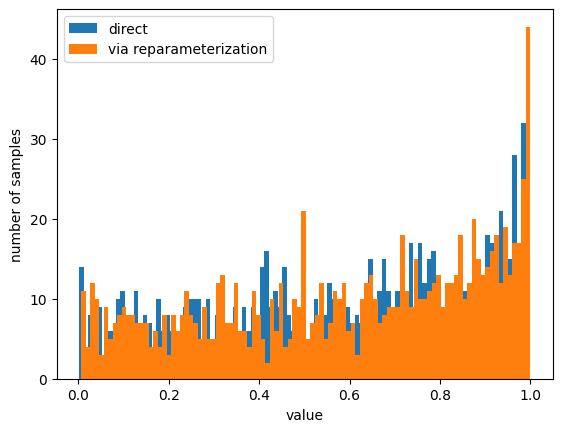

In [6]:
compare_samples (direct_samples, reparametrized_samples)

### ***Q2. Dirichlet Distribution***


Write a function that generates N samples from Dirichlet ($\alpha$), where $\alpha = [\alpha_0, \alpha_1, \alpha_2]$.

In [9]:
def dirichlet_sampler(alpha, N):
  # insert your code
  dirichlet = torch.distributions.Dirichlet(alpha)
  samples = dirichlet.sample((N,))

  return samples  # should be N-by-3

Implement the reparameterization trick for the Dirichlet distribution:

In [7]:
# Hint: approximate it by the Softmax-Gaussian distribution.
def dirichlet_reparametrize(alpha, N):
    """
    Approximate sampling from Dirichlet(alpha) by using a logistic-normal
    (a.k.a. Softmax-Gaussian) reparameterization.
    
    Args:
        alpha (torch.Tensor): Concentration parameters of shape (K,).
        N (int): Number of samples to generate.
    
    Returns:
        torch.Tensor: A tensor of shape (N, K) containing approximate samples
                      from Dirichlet(alpha). Each row sums to ~1.
    """
    # alpha is assumed to be a 1D tensor of length K
    # For numerical stability, ensure alpha > 0
    if (alpha <= 0).any():
        raise ValueError("All Dirichlet concentration parameters (alpha) must be > 0.")
    
    # Step 1: Define mean and (diagonal) standard deviation
    # A common heuristic: mean = log(alpha), std = 1 / sqrt(alpha).
    mu = torch.log(alpha)
    sigma = 1.0 / torch.sqrt(alpha)
    
    # Expand to shape (N, K)
    mu = mu.unsqueeze(0).expand(N, -1)       # shape: (N, K)
    sigma = sigma.unsqueeze(0).expand(N, -1) # shape: (N, K)
    
    # Step 2: Sample N x K standard normals
    eps = torch.randn_like(mu)  # shape: (N, K)
    
    # Step 3: Create z ~ Normal(mu, diag(sigma^2))
    z = mu + sigma * eps  # shape: (N, K)
    
    # Step 4: Convert to simplex via softmax
    # shape: (N, K), each row sums to ~1
    samples = torch.softmax(z, dim=-1)
    
    return samples

Generate samples for $\alpha= [1, 10, 1]$:

In [10]:
alpha = torch.Tensor([1, 10, 1])
N = 100
direct_samples = dirichlet_sampler(alpha, N)
reparametrized_samples = dirichlet_reparametrize(alpha, N)

A helper function to visualize dirichlet samples:

In [11]:
def dirichlet_plotter (samples_1, samples_2, idx):
  fig = plt.figure()

  plt.bar([1,2,3], samples_1[idx,:])
  plt.xlabel('categories')
  plt.ylabel('prob')
  plt.title('direct sampling')
  plt.xticks([1, 2, 3], ['1', '2', '3'])
  fig = plt.figure()
  plt.bar([1,2,3], samples_2[idx,:])
  plt.xlabel('categories')
  plt.ylabel('prob')
  plt.title('via reparametrization')
  plt.xticks([1, 2, 3], ['1', '2', '3'])
  plt.show()

Compare the samples drawn from the Dirichlet distribution and the samples drawn from the reparametrized version of it (do it for a few different idx):

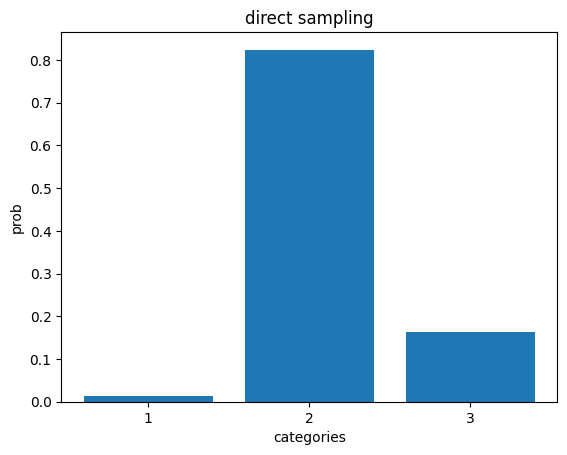

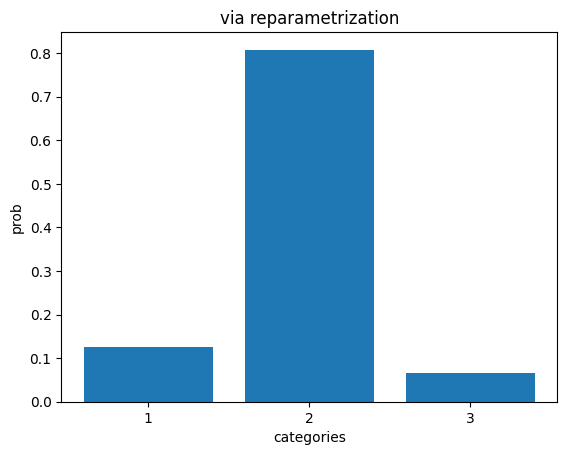

In [12]:
dirichlet_plotter(direct_samples, reparametrized_samples, idx=1) # idx= 0, 1, ..., N